# Pose Error Project

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import sys
import time
import pickle
import json
import copy

#from tqdm import tqdm
# since we are using it in jupyter notebook
from tqdm.notebook import tqdm

import random
random.seed(2024)

import torch
torch.manual_seed(2024)
from torch.utils.data import DataLoader

import torch.utils.tensorboard as tb 
from torch.utils.tensorboard import SummaryWriter
%reload_ext tensorboard
writer = SummaryWriter()

from deepSEEConfig import DeepSEEConfig

import logging
logging.basicConfig(filename='running.log', encoding='utf-8', level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.info("Loading packages ...")


/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
from ts2vec.ts2vec import TS2Vec

# Setup Configurations

In [3]:
config = DeepSEEConfig(seed=2024, n_proc=8, window_step=5, lr=1e-6, epochs=2, batchsize=128,
                    data_dir="/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data",
                    datasets=['SenseTime', 'LivingRoom','Hall','Lab', 'Lab2', 'Apartment', \
                        'FireStationOffice', 'FireStationKitchen', 'FireStationGarage', \
                        'AbandonedFactory'],
                    target_transform=True,
                    )

In [4]:
logger.info("Configuration")
logger.info(config)
config

DeepSEEConfig {
  "batchsize": 128,
  "data_dir": "/mnt/857a1489-020d-4d83-9753-e0ac37876d29/DeepSEE_Data",
  "datasets": [
    "SenseTime",
    "LivingRoom",
    "Hall",
    "Lab",
    "Lab2",
    "Apartment",
    "FireStationOffice",
    "FireStationKitchen",
    "FireStationGarage",
    "AbandonedFactory"
  ],
  "device": "cuda",
  "epochs": 2,
  "lr": 1e-06,
  "n_proc": 8,
  "seed": 2024,
  "target_transform": true,
  "transformers_version": "4.36.1",
  "window_length": 30,
  "window_step": 5
}

# Prepare Data

In [5]:
from datasets.data import DeepSEEData

In [6]:
logger.info("Loading and preprocessing data ...")
slam_data = DeepSEEData(root_dir=config.data_dir, 
                        dataset_list=config.datasets,
                        n_proc=config.n_proc, 
                        config=config)

Loading DeepSEE-SenseTime dataset
Loading DeepSEE-LivingRoom dataset
Loading DeepSEE-Hall dataset
Loading DeepSEE-Lab dataset
Loading DeepSEE-Lab2 dataset
Loading DeepSEE-Apartment dataset
Loading DeepSEE-FireStationOffice dataset
Loading DeepSEE-FireStationKitchen dataset
Loading DeepSEE-FireStationGarage dataset
Loading DeepSEE-AbandonedFactory dataset


# Split Dataset

In [ ]:
train_data = {}
val_data = {}
test_data = {}

split_config = {
    "unsup_pretrain_traj": {
        "Apartment":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "FireStationOffice":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "FireStationKitchen":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "FireStationGarage":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "AbandonedFactory":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "Lab":['A0','A1','A2','A3','A4','A5','A6','A7'],
        "Lab2":['A0','A1','A2','A3','A4','A5','A6','A7'],
        "LivingRoom":['A0','A1','A2','A3','A4','A5','A6','A7'],
        "Hall":['A0','A1','A2','A3','A4','A5','A6','A7'],
        "SenseTime":['A1','A2','A3','A4','A5','A6','A7', 'B0','B1','B2','B3','B4','B5','B6','B7']

    },
    "sup_pretrain_train_traj": {
        "FireStationOffice":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "FireStationKitchen":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "FireStationGarage":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "AbandonedFactory":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
        "Lab":['A0','A1','A2','A3','A4','A5','A6','A7'],
        "Lab2":['A0','A1','A2','A3','A4','A5','A6','A7'],
        "Hall":['A0','A1','A2','A3','A4','A5','A6','A7'],
        "LivingRoom":['A0','A1','A2','A3','A4','A5','A6','A7'],
    },
    "sup_pretrain_val_traj": {
        "Apartment":['A0','A1','A2','A3','A4','A5','A6','A7',\
                     'B0','B1','B2','B3','B4','B5','B6','B7'],
    },
    "sup_pretrain_test_traj": {
        "SenseTime":['A1','A2','A3','A4','A5','A6','A7','B0','B1','B2','B3','B4','B5','B6','B7']
    }
}

In [8]:
def assign_traj(slam_data, set_config):
    set_data = {}
    dataset_list = list(set_config.keys())

    for dataset in dataset_list:
        set_data[dataset] = {}
        for traj in set_config[dataset]:
            try:
                set_data[dataset][traj] = slam_data.data[dataset][traj]
            except:
                print("Could not find trajectory: {} in {}".format(traj, dataset))
                pass

    return set_data

In [9]:
unsup_pretrain_data = assign_traj(slam_data, split_config["unsup_pretrain_traj"])

sup_pretrain_train_data = assign_traj(slam_data, split_config["sup_pretrain_train_traj"])
sup_pretrain_val_data = assign_traj(slam_data, split_config["sup_pretrain_val_traj"])
sup_pretrain_test_data = assign_traj(slam_data, split_config["sup_pretrain_test_traj"])

# Dataset

In [10]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from datasets import augmentation


class SLAMDataset(Dataset):
    """SLAM dataset"""

    def __init__(self, slam_data, augment=False, onlyOneIter=False, lower=None, upper=None, std=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.slam_data = slam_data
        self.onlyOneIter = onlyOneIter
        self.generate_sample_list(slam_data)
        self.augment = augment
        self.lower = lower
        self.upper = upper
        self.std = std
        

    def generate_sample_list(self, slam_data):
        self.sample_list = []
        for i, dataset in enumerate(list(slam_data.keys())):
            for j, traj in enumerate(list(slam_data[dataset].keys())):
                for m, iter in enumerate(list(slam_data[dataset][traj].keys())):
                    for n, time_stamp in enumerate(list(slam_data[dataset][traj][iter].keys())):
                        if self.onlyOneIter:
                            if m == 0: # Only take the first iteration
                                self.sample_list.append([dataset, traj, iter, time_stamp])
                        else:
                            self.sample_list.append([dataset, traj, iter, time_stamp])

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        dataset, traj, iter, time_stamp = self.sample_list[idx]
        data_dict = self.slam_data[dataset][traj][iter][time_stamp]

        time_series = data_dict['timeSeries'].values
        point_dist = data_dict['pointDist']
        relative_error = data_dict['relativeError']

        if self.lower is not None:
            time_series = np.where(time_series < self.lower, self.lower, time_series)
            time_series = np.where(time_series > self.upper, self.upper, time_series)
            time_series = time_series / self.std

        if self.augment:
            #if random.random() < 0.1:
            x = np.expand_dims(time_series, axis=0) # shape (1, time, channel)
            x = augmentation.jitter(x, sigma=0.03)
            x = augmentation.scaling(x, sigma=0.1)
            #x = augmentation.time_warp(x, sigma=0.1, knot=3)
            x = augmentation.window_warp(x, window_ratio=0.1, scales=[0.75,1.25])
            time_series = x.squeeze()
                
        sample = {'time_series': torch.from_numpy(time_series), 
                  'point_dist': torch.from_numpy(point_dist), 
                  'relative_error': torch.tensor(relative_error).reshape([1])}

        
        return sample

In [11]:
unsup_pretrain_set = SLAMDataset(unsup_pretrain_data, augment=False)

In [12]:
# Deal with outlier features
# Extract all data and labels
dataset = unsup_pretrain_set
all_data = []
all_labels = []
for i in range(len(dataset)):
    data = dataset[i]['time_series']
    all_data.append(data[0])

# Stack all the data and labels to form tensors
all_data = torch.stack(all_data).numpy()
all_data.shape

(119553, 16)

In [ ]:
# Function to remove outliers using IQR for numpy arrays
def remove_outliers_iqr(data):
    # Calculate Q1 and Q3 along each column
    Q1 = np.percentile(data, 10, axis=0)
    Q3 = np.percentile(data, 90, axis=0)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [14]:
lower_bound, upper_bound = remove_outliers_iqr(all_data)

In [16]:
lower_bound

array([-0.4098927 , -0.71847845,  0.32280563,  0.54254037, -0.21441552,
       -0.7186016 , -0.32833333, -0.485     , -0.54375   , -1.56301035,
       -2.45014408, -1.23139732, -0.03738015, -0.03376492, -0.04914277,
        0.69843085])

In [17]:
upper_bound

array([1.72494812, 1.74280104, 1.32269602, 1.34493171, 1.39295088,
       1.421328  , 1.365     , 1.315     , 1.90625   , 1.78624733,
       2.4267788 , 1.085139  , 0.06509871, 0.03452624, 0.05342298,
       1.119139  ])

In [18]:
len(np.where(all_data < lower_bound)[1])

3292

In [ ]:
# Clip the data to the bounds
capped_data = np.where(all_data < lower_bound, lower_bound, all_data)
capped_data = np.where(capped_data > upper_bound, upper_bound, capped_data)

In [20]:
capped_data[0]

array([ 5.04456300e-01,  4.42660686e-01,  7.83595875e-01,  9.64483889e-01,
        5.66904000e-01,  1.78040000e-01,  7.70000000e-01,  4.40000000e-01,
        1.04500000e+00,  6.53051000e-02,  8.98475400e-01, -8.66205000e-02,
        1.62761999e-04,  9.41778861e-04,  4.83005522e-03,  8.54739338e-01])

In [21]:
std = np.std(capped_data, axis=0)

In [22]:
std_data = capped_data/std

In [23]:
np.std(std_data, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [24]:
unsup_pretrain_set = SLAMDataset(unsup_pretrain_data, augment=False, lower=lower_bound, upper=upper_bound, std=std)

sup_pretrain_train_set = SLAMDataset(sup_pretrain_train_data, augment=False, lower=lower_bound, upper=upper_bound, std=std)
sup_pretrain_val_set = SLAMDataset(sup_pretrain_val_data, augment=False, onlyOneIter=True, lower=lower_bound, upper=upper_bound, std=std)
sup_pretrain_test_set = SLAMDataset(sup_pretrain_test_data, augment=False, onlyOneIter=True, lower=lower_bound, upper=upper_bound, std=std)


### Unsupervised Pretrain - RTS Encoder

In [26]:
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt

In [27]:
# Whether to use unsupervised pretraining
b_unsup_pretrain = True
# Whether to reload previous unsupervised pretraining result
b_reload_unsup_pretrain = False

In [ ]:
# It may take a while
if b_unsup_pretrain:
    pretrain_dataset = []
    for i in range(len(unsup_pretrain_set)):
        instance_i = unsup_pretrain_set[i]['time_series'].unsqueeze(dim=0).numpy()
        pretrain_dataset.append(instance_i)
        if(i % 10000 == 0):
            print(f"processing {i}th instance")
    random.shuffle(pretrain_dataset)
    pretrain_dataset = np.concatenate(pretrain_dataset, axis=0)

processing 0th instance
processing 10000th instance
processing 20000th instance
processing 30000th instance
processing 40000th instance
processing 50000th instance
processing 60000th instance
processing 70000th instance
processing 80000th instance
processing 90000th instance
processing 100000th instance
processing 110000th instance


In [29]:
if b_unsup_pretrain:
    pretrain_model = TS2Vec(input_dims=pretrain_dataset.shape[-1],
                            device=0,
                            batch_size=128,
                            output_dims=64
                            )

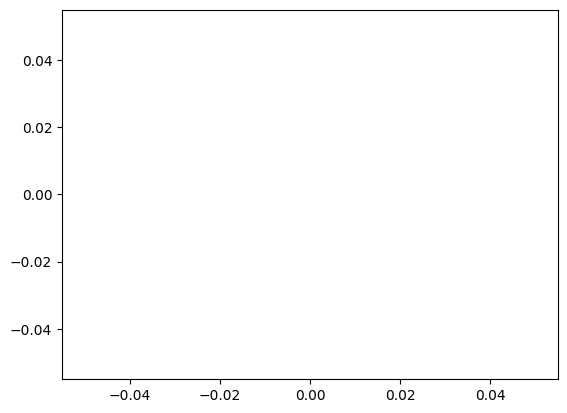

In [30]:
if b_unsup_pretrain:
    if b_reload_unsup_pretrain:
        trained_model_folder = 'runs/May23_13-59-28_i3t-server'
        state_dict = torch.load(trained_model_folder + "/pretrained_model.pkl")
        pretrain_model.net.load_state_dict(state_dict)
    else:
        
        loss_log = pretrain_model.fit(
            pretrain_dataset,
            #n_epochs=50,
            #n_epochs=2,
            n_iters=600,#600,
            verbose=True
        )

        pretrain_model.save(writer.get_logdir() + "/pretrained_model.pkl")
        with open(writer.get_logdir() + "/pretrained_loss.txt", 'w') as f:
            for loss in loss_log:
                f.write(f"{loss}\n")

        plt.plot(loss_log)
        plt.show()


In [31]:
#pretrain_model.encode(pretrain_dataset[0:64]).shape

#### PSD Encoder self-supervised training

In [32]:
from models.DeepSEEModels import TimesformerConfig, TimesformerModel
from models.DeepSEEModels import PointDistProjection, MultiModalCrossAttentionConfig

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
# PD: Point distribution
config_PD = TimesformerConfig(image_size = 128,
                             patch_size = 8,
                             num_channels = 3,
                             num_frames = 4,
                             num_hidden_layers = 3,
                             num_attention_heads = 12,
                             hidden_size = 192,
                             intermediate_size = 256,
                             hidden_dropout_prob = 0)

config_CA = MultiModalCrossAttentionConfig(
                                        ts2vec_only = True,
                                        ts2vec_dim = 64,
                                        # Time Series
                                        ts_context_length = 30,
                                        ts_patch_len = 5,
                                        ts_num_input_channels = 64,
                                        ts_patch_stride = 5,
                                        ts_d_model = 192,
                                        ts_time_step = 33, 
                                        # PD parameter
                                        pd_d_model = 192,
                                        pd_time_step = 33*10,
                                        pe_max_len = 10000, 
                                        # CA
                                        ca_d_model = 128, 
                                        ca_num_head = 16,
                                        ca_num_layers = 2,
                                        ca_dropout = 0.0, 
                                        ca_time_series_only=False, 
                                        output_range=None
                                    )

In [34]:
class PSDSSL(torch.nn.Module):
    def __init__(self, pd_config: TimesformerConfig, config):
        super().__init__()        
        
        self.pd_config = pd_config
        
        # Encoder
        self.pd_encoder = TimesformerModel(pd_config)

        #self.pd_proj = PointDistProjection(config)

        self.fc1 = torch.nn.Linear(192, 192)
        self.fc2 = torch.nn.Linear(192, 192)

        
    def forward(self, point_dist):
        #x_pd = torch.rand((1, 4, 3, 96, 128))#
        # pd shape: ((Bs, 4, 3, 96, 128))#
        #                 4  : 12 * 16
        
        # Random Mask
        batch_size = point_dist.shape[0]
        binary_mask = torch.ones((batch_size, 4, 3, 12, 16), dtype=torch.float).to(point_dist.device)

        mask_indices = torch.randint(0, 4, (batch_size, 12, 16))#.to(point_dist.device)
        mask_indices1 = torch.randint(0, 4, (batch_size, 12, 16))#.to(point_dist.device)


        # Construct the mask
        for i in range(batch_size):
            for j in range(12):
                for k in range(16):
                    binary_mask[i, mask_indices[i,j,k], :, j, k] = 0
                    binary_mask[i, mask_indices1[i,j,k], :, j, k] = 0
        
        mask_indices = torch.randint(0, 4, (batch_size, 12, 16)).to(point_dist.device)

                    
        binary_mask = torch.nn.functional.interpolate(binary_mask, scale_factor=(1,8,8), mode="nearest")

        # Apply the mask
        masked_x_pd = point_dist * binary_mask

        pd_hs = self.pd_encoder(masked_x_pd).last_hidden_state
        #pd_hs = self.pd_proj(pd_hs)

        patch_height, patch_width, pd_num_frame = 12,16,4
        pd_d_model = self.pd_config.hidden_size

        # pd_hidden_state.shape
        # (batch_size, 1 + H//P * W//P * T, hidden_size)
        # Drop the [CLS] token in the front
        pd_hs = pd_hs[:,1:,:]
        # Time-preserved reshape
        #print("PD Projection Shape {}".format(hidden_state.shape))
        pd_hs = pd_hs.view(batch_size, 
                            patch_height, patch_width,
                            pd_num_frame, 
                            pd_d_model
                        ).reshape(
                            batch_size,
                            patch_height*patch_width, pd_num_frame, pd_d_model)
        # Shape (BS, 12*16, 4, 192)
        pd_hs = pd_hs.permute(0, 2, 1, 3)
        pd_hs = pd_hs.reshape(batch_size, pd_num_frame, patch_height*patch_width, pd_d_model)

        pd_hs = self.fc1(pd_hs)
        pd_hs = torch.nn.functional.gelu(pd_hs)
        pd_hs = self.fc2(pd_hs)

        pd_hs = pd_hs.view(batch_size, pd_num_frame, patch_height, patch_width, 3, 8, 8)
        pd_hs = pd_hs.permute(0, 1, 4, 2, 5, 3, 6) # (batch_size, pd_num_frame, 3, patch_height,8, patch_width, 8)
        
        y_pd = pd_hs.reshape(batch_size,4,3,96,128)
        
        return y_pd

In [35]:
psd_ssl_model = PSDSSL(config_PD, config_CA)

In [36]:
x_pd = torch.rand((5, 4, 3, 96, 128))#.to(device)

In [37]:
y_pd = psd_ssl_model.forward(x_pd)

In [38]:
from accelerate import Accelerator
from accelerate.utils import set_seed
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler
from transformers import get_constant_schedule_with_warmup

In [39]:
def loss_fn(outputs, targets, device):
    return torch.nn.MSELoss()(outputs, targets)

In [ ]:
def PSD_Pretrain(model, pretrain_loader):
    set_seed(config.seed)
    accelerator = Accelerator(mixed_precision="bf16")
    #accelerator.device = config.device
    #optimizer = AdamW(model.parameters(), lr=config.lr)
    optimizer = AdamW(model.parameters(), lr=1e-3)

    num_epochs = 30 #config.epochs
    num_training_steps = num_epochs * len(pretrain_loader)
    lr_scheduler = get_scheduler(
        "constant_with_warmup", #"linear", #"constant_with_warmup",
        optimizer=optimizer,
        num_warmup_steps= int(0.05*num_training_steps),
        num_training_steps=num_training_steps,
    )

    pretrain_dl, model, optimizer, lr_scheduler = accelerator.prepare(
        pretrain_loader,
        model, 
        optimizer,
        lr_scheduler
    )

    model = model.to(accelerator.device)

    progress_bar = tqdm(range(num_training_steps))
    epoch_loss = []

    for epoch in range(num_epochs):
        
        model.train()
        counter = 0
        train_loss_list = []
        for batch in pretrain_dl:
            point_dist = batch['point_dist'].to(accelerator.device, dtype = torch.float)

            outputs = model(point_dist)
            loss = loss_fn(point_dist, outputs, accelerator.device)
            train_loss_list.append(loss.item())

            # if(counter%10==0):
            #     print(f'Epoch: {epoch}, Iter: {counter}, Loss:  {np.mean(train_loss_list)}')

            accelerator.backward(loss)


            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            counter += 1

            progress_bar.update(1)

        epoch_loss.append(np.mean(train_loss_list))
        print(f'Epoch: {epoch}, Loss:  {np.mean(train_loss_list)}')
    return model, epoch_loss

In [41]:
pretrain_params = {'batch_size': config.batchsize,
                'shuffle': True,
                'num_workers': 8
                }
pretrain_loader = DataLoader(unsup_pretrain_set, **pretrain_params)


In [ ]:
# Pretain the PSD Encoder
if True:
    psd_ssl_model , epoch_loss = PSD_Pretrain(psd_ssl_model, pretrain_loader)
    # Save model
    torch.save(psd_ssl_model.pd_encoder.state_dict(), writer.get_logdir() + "/psd_ssl_model.pth")

# Supervised Pretraining
### Data Loader

In [44]:
len(sup_pretrain_train_set)

84871

In [45]:
len(sup_pretrain_val_set)

5056

In [46]:
len(sup_pretrain_test_set)

3710

# Model - Baseline

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def global_pooling_1D(features):
    mean_features = torch.mean(features, dim=0)
    return mean_features

In [ ]:
# Remove the following internal SLAM features from X:
# matched inliers, ourliers, PrePOKeyMapLoss, avgMPDepth, VarMPDepth, LocalMappingError
#
#  ['Brightness','Contrast','Entropy','Laplacian', 
# 'AvgMPDepth','VarMPDepth','PrePOKeyMapLoss',\
# 'PostPOOutlier', 'MatchedInlier',\
# 'DX','DY','DZ','Yaw','Pitch','Roll',\
# 'local_visual_BA_Err']
# X_train shape torch.Size([2749, 16])
indices_to_remove = [4,5,6,7,8,15]
# Get all column indices
all_indices = torch.arange(16)
# Create a mask to keep columns not in indices_to_remove
mask = ~torch.tensor([i in indices_to_remove for i in all_indices])

def load_data_from_dataset(dataset):
    X = []
    Y = []
    for idx in range(len(dataset)):
        X.append(global_pooling_1D(dataset[idx]['time_series']).unsqueeze(dim=0))
        Y.append(dataset[idx]['relative_error'].unsqueeze(dim=0))

    X = torch.cat(tuple(X), dim=0)
    Y = torch.cat(tuple(Y), dim=0)

    X_select = X[:, mask]

    return X_select, Y

In [50]:
def ensemble_tree_data_loader(train_set, val_set, test_set):
    X_train, Y_train = load_data_from_dataset(train_set)
    X_val, Y_val = load_data_from_dataset(val_set)
    X_test, Y_test = load_data_from_dataset(test_set)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# Model - DeepSEE

In [51]:
from models.DeepSEEModels import TimesformerConfig, PatchTSMixerConfig, MultiModalCrossAttentionConfig
from models.DeepSEEModels import DeepSEEModel

In [52]:
# PD: Point distribution
config_PD = TimesformerConfig(image_size = 128,
                             patch_size = 8,
                             num_channels = 3,
                             num_frames = 4,
                             num_hidden_layers = 3,
                             num_attention_heads = 12,
                             hidden_size = 192,
                             intermediate_size = 256,
                             #hidden_dropout_prob = 0.1)
                             hidden_dropout_prob = 0)

In [ ]:
if b_unsup_pretrain:
    config_TS = PatchTSMixerConfig(context_length = 30, 
                                prediction_length = 1,
                                num_input_channels = 64, 
                                d_model = 192,
                                patch_len = 10,
                                patch_stride = 5,
                                use_positional_encoding = True,
                                ca_d_model = 128,
                                num_layers = 3,
                                drop_out = 0.0
                            )
else:
    config_TS = PatchTSMixerConfig(context_length = 30, 
                                prediction_length = 1,
                                num_input_channels = 16, 
                                d_model = 192,
                                patch_len = 10,
                                patch_stride = 5,
                                use_positional_encoding = True,
                                ca_d_model = 128,
                                num_layers = 3,
                                drop_out = 0.0
                            )

In [ ]:
if b_unsup_pretrain:
    config_CA = MultiModalCrossAttentionConfig(
                                            ts2vec_only = True,
                                            ts2vec_dim = 64,
                                            # Time Series
                                            ts_context_length = 30,
                                            ts_patch_len = 5,
                                            #ts_num_input_channels = 16,
                                            ts_num_input_channels = 64,
                                            ts_patch_stride = 5,
                                            ts_d_model = 192,
                                            ts_time_step = 33, 
                                            # PD parameter
                                            pd_d_model = 192,
                                            pd_time_step = 33*10,
                                            pe_max_len = 10000, 
                                            # CA
                                            ca_d_model = 128, 
                                            ca_num_head = 16, 
                                            ca_num_layers = 2, 
                                            ca_dropout = 0.0, 
                                            ca_time_series_only=False, 
                                            output_range=None
                                        )
else:
    config_CA = MultiModalCrossAttentionConfig(ts_context_length = 30,
                                            ts_patch_len = 5,
                                            ts_num_input_channels = 16,
                                            #ts_num_input_channels = 64,
                                            ts_patch_stride = 5,
                                            ts_d_model = 192,
                                            ts_time_step = 33,
                                            # PD parameter
                                            pd_d_model = 192,
                                            pd_time_step = 33*10,
                                            pe_max_len = 10000, 
                                            # CA
                                            ca_d_model = 128, 
                                            ca_num_head = 16, 
                                            ca_num_layers = 2, 
                                            ca_dropout = 0.0, 
                                            ca_time_series_only=False, 
                                            output_range=None
                                        )

In [55]:
model = DeepSEEModel(config_PD, config_TS, config_CA)

In [ ]:
# Load PSD Encoder weights
model.pd_encoder.load_state_dict(torch.load(writer.get_logdir() + "/psd_ssl_model.pth"))

<All keys matched successfully>

In [57]:
config_CA

MultiModalCrossAttentionConfig {
  "ca_d_model": 128,
  "ca_dropout": 0.0,
  "ca_num_head": 16,
  "ca_num_layers": 2,
  "ca_time_series_only": false,
  "output_range": null,
  "pd_d_model": 192,
  "pd_height": 128,
  "pd_num_frame": 4,
  "pd_patch_size": 8,
  "pd_time_step": 330,
  "pd_width": 96,
  "pe_max_len": 10000,
  "reg_d_fc": 128,
  "reg_dropout": 0.0,
  "transformers_version": "4.36.1",
  "ts2vec_dim": 64,
  "ts2vec_only": true,
  "ts_context_length": 30,
  "ts_d_model": 192,
  "ts_num_input_channels": 64,
  "ts_patch_len": 5,
  "ts_patch_stride": 5,
  "ts_time_step": 33
}

In [58]:
#model.compile()

In [59]:
%%timeit

# # dummy_TS
if b_unsup_pretrain:
    x_ts = torch.rand((1, 30, 64))###.to(device)
else:
    x_ts = torch.rand((1, 30, 16))###.to(device)
x_pd = torch.rand((1, 4, 3, 96, 128))#.to(device)
model(x_pd,x_ts)

15.8 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Supervised Pretrain

In [60]:
from torchmetrics.regression import MeanAbsolutePercentageError
import numpy as np

In [61]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=config.lr)

In [62]:
class WeightedMSELoss(torch.nn.Module):
    def __init__(self, alpha=1.0):
        """
        Initializes the WeightedMSELoss module.
        :param alpha: Controls the influence of the label value on the loss weighting.
        """
        super(WeightedMSELoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        """
        Computes the weighted MSE loss.
        :param predictions: The predicted values from the model.
        :param targets: The actual target values from the dataset.
        :return: The computed weighted MSE loss.
        """
        with torch.no_grad():
            weights = (1 + self.alpha * targets) ** 4  # Compute weights as the square of (1 + alpha * targets)
        loss = (predictions - targets) ** 2
        weighted_loss = weights * loss
        return torch.mean(weighted_loss)

In [ ]:
def loss_fn(outputs, targets, device):
    return  MeanAbsolutePercentageError().to(device)(outputs,targets)*2 + torch.nn.MSELoss().to(device)(outputs, targets)
 

In [64]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, ouput_folder, file_name='best_model'
    ):
        if epoch >= 1:
            if current_valid_loss < self.best_valid_loss:
                self.best_valid_loss = current_valid_loss
                print(f"\nBest validation loss: {self.best_valid_loss}")
                print(f"\nSaving best model for epoch: {epoch+1}\n")
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': criterion,
                    }, '{}/{}.pth'.format(ouput_folder, file_name))


def save_model(epochs, model, optimizer, criterion, output_folder, file_name='final_model'):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '{}/{}.pth'.format(output_folder, file_name))

In [65]:
from accelerate import Accelerator
from accelerate.utils import set_seed
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

In [ ]:
def train_with_validation(model, train_loader, val_loader, test_loader, config, mode="SupervisedPretrain"):
    set_seed(config.seed)
    accelerator = Accelerator(mixed_precision="bf16")
    optimizer = AdamW(model.parameters(), lr=config.lr)

    num_epochs = config.epochs
    num_training_steps = num_epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        "constant_with_warmup",#"linear",
        optimizer=optimizer,
        num_warmup_steps= int(0.1*num_training_steps),
        num_training_steps=num_training_steps,
    )

    train_dl, val_dl, test_dl, model, optimizer, lr_scheduler = accelerator.prepare(
        train_loader, val_loader, test_loader,
        model, 
        optimizer,
        lr_scheduler
    )

    model = model.to(accelerator.device)

    for param in model.pd_encoder.parameters():
        param.requires_grad = False

    # initialize SaveBestModel class
    save_best_model = SaveBestModel()

    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(num_epochs):
        
        model.train()
        counter = 0
        train_loss_list = []
        for batch in train_dl:
            if b_unsup_pretrain:
                time_series = pretrain_model.encode(batch['time_series'].cpu().numpy(), causal=True, sliding_length=1, sliding_padding=5)
                time_series = torch.from_numpy(time_series).to(accelerator.device, dtype = torch.float)
            else:
                time_series = batch['time_series'].to(accelerator.device, dtype = torch.float)
            
            point_dist = batch['point_dist'].to(accelerator.device, dtype = torch.float)
            relative_error = batch['relative_error'].to(accelerator.device, dtype = torch.float)

            outputs = model(point_dist, time_series)
            loss = loss_fn(outputs, relative_error, accelerator.device)
            train_loss_list.append(loss.item())

            # if(counter%10==0):
            #     print(f'Epoch: {epoch}, Iter: {counter}, Loss:  {np.mean(train_loss_list)}')

            # ...log the running loss
            writer.add_scalar(f'{mode} training loss', loss, epoch * len(train_dl) + counter)

            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            counter += 1

            progress_bar.update(1)

        writer.add_scalar(f'{mode} training epoch loss', np.mean(train_loss_list), epoch)


        model.eval()
        counter = 0
        val_loss_list = []
        for batch in val_dl:
            if b_unsup_pretrain:
                time_series = pretrain_model.encode(batch['time_series'].cpu().numpy(), causal=True, sliding_length=1, sliding_padding=5)
                time_series = torch.from_numpy(time_series).to(accelerator.device, dtype = torch.float)
            else:
                time_series = batch['time_series'].to(accelerator.device, dtype = torch.float)
            
            point_dist = batch['point_dist'].to(accelerator.device, dtype = torch.float)
            relative_error = batch['relative_error'].to(accelerator.device, dtype = torch.float)

            with torch.no_grad():
                outputs = model(point_dist, time_series)
                all_outputs, all_relative_errors = accelerator.gather_for_metrics((outputs, relative_error))
                loss = loss_fn(all_outputs, all_relative_errors, accelerator.device)
                val_loss_list.append(loss.item())
                # ...log the running loss
                writer.add_scalar(f'{mode} validation loss', loss, epoch * len(val_dl) + counter)
            counter += 1

        val_epoch_loss = np.mean(val_loss_list)
        writer.add_scalar(f'{mode} validation epoch loss', val_epoch_loss, epoch)
        save_best_model(
            val_epoch_loss, epoch, model, optimizer, loss_fn, writer.get_logdir(), f"{mode}_best_model"
        )

    # save the trained model weights for a final time
    save_model(num_epochs, model, optimizer, loss_fn, writer.get_logdir()), f"{mode}_final_model"

    return model



In [67]:
train_params = {'batch_size': config.batchsize,
                'shuffle': True,
                'num_workers': 8
                }

val_params = {'batch_size': config.batchsize,
                'shuffle': True,
                'num_workers': 8
                }

test_params = {'batch_size': config.batchsize,
                'shuffle': False,
                'num_workers': 8
                }

In [68]:
train_loader = DataLoader(sup_pretrain_train_set, **train_params)
val_loader = DataLoader(sup_pretrain_val_set, **val_params)
test_loader = DataLoader(sup_pretrain_test_set, **test_params)

In [69]:
config.epochs=2

In [70]:
model = train_with_validation(model, train_loader, val_loader, test_loader, config, mode="SupervisedPretrain")

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1328 [00:00<?, ?it/s]


Best validation loss: 0.7412907406687737

Saving best model for epoch: 2

Saving final model...


# Supervised Pretrain Evaluation

In [71]:
import torch
import matplotlib.pyplot as plt

In [72]:
from sklearn.metrics import mean_absolute_percentage_error

In [73]:
def get_mse(y_gt,y_est):
    assert(y_gt.shape == y_est.shape)
    return np.mean((y_gt - y_est) ** 2)

def get_mape(y_gt,y_est):
    assert(y_gt.shape == y_est.shape)
    return mean_absolute_percentage_error(y_gt, y_est)

In [74]:
from scipy.ndimage import uniform_filter

In [ ]:

def plot_result_on_testset(Y_gt, Y_est, YT_test_head=None, mode="SupervisedPretrain", target_transform=False):
    # Concatenate tensors along the specified dimension (0 for row-wise concatenation)
    Y_gt_np = torch.cat(Y_gt, dim=0).cpu().numpy()
    Y_est_np = torch.cat(Y_est, dim=0).cpu().numpy()

    np.save(writer.get_logdir()+f"/{mode}_Y_gt.npy", Y_gt_np)
    np.save(writer.get_logdir()+f"/{mode}_Y_est.npy", Y_est_np)

    if target_transform:
        Y_gt_np = (np.exp(Y_gt_np)-1)/10000
        Y_est_np = (np.exp(Y_est_np)-1)/10000
    
    # Plotting
    plt.figure(figsize=(20,5))

    plt.plot(Y_gt_np, c='g', alpha=0.75, label="GT")
    plt.plot(Y_est_np, c='b', alpha=0.5, label="DeepSEE")
    
    if YT_test_head is not None:
        Y_base_np = np.expand_dims(YT_test_head, axis=1)
        np.save(writer.get_logdir()+f"/{mode}_Y_base.npy", Y_base_np)
        if target_transform:
            Y_base_np = (np.exp(Y_base_np)-1)/10000
        plt.plot(Y_base_np, c='r', alpha=0.25, label="Base")

    plt.xlabel('Index')
    plt.ylabel('Value')
    if YT_test_head is not None:
        plt.title('Pose Error Estimatioin on Test Set - DeepSEE MSE: {:.6f} MAPE: {:.6f} - Baseline MSE: {:.6f} MAPE: {:.6f}'.format(get_mse(Y_gt_np,Y_est_np), 
                                                                                                                                     get_mape(Y_gt_np,Y_est_np),
                                                                                                                                     get_mse(Y_gt_np, Y_base_np),
                                                                                                                                     get_mape(Y_gt_np,Y_base_np)))
    else:
        plt.title('Pose Error Estimatioin on Test Set - DeepSEE MSE: {:.6f}  MAPE: {:.6f}'.format(get_mse(Y_gt_np,Y_est_np), get_mape(Y_gt_np,Y_est_np)))
    plt.grid(True)
    plt.legend()
    #writer.add_figure("On testset", plt.gcf(),0)
    plt.savefig(writer.get_logdir()+f"/{mode}_Evaluation.png")
    plt.show()

In [76]:
# load the best model checkpoint
best_model_cp = torch.load('{}/SupervisedPretrain_best_model.pth'.format(writer.get_logdir()))
best_model_epoch = best_model_cp['epoch']
model.load_state_dict(best_model_cp['model_state_dict'])
print(f"Best Supervised Pretrained model was saved at {best_model_epoch} epochs\n")

Best Supervised Pretrained model was saved at 2 epochs



In [ ]:
def evaluate_on_test(model, test_loader, YT_test_head=None, mode="SupervisePretrain"):
    set_seed(config.seed)
    accelerator = Accelerator(mixed_precision="bf16")
    model, test_dl  = accelerator.prepare(model, test_loader)
    model.eval()
    counter = 0

    Y_gt = []
    Y_est = []

    for batch in test_dl:
        if b_unsup_pretrain:
            time_series = pretrain_model.encode(batch['time_series'].cpu().numpy(), causal=True, sliding_length=1, sliding_padding=5)
            time_series = torch.from_numpy(time_series).to(accelerator.device, dtype = torch.float)
        else:
            time_series = batch['time_series'].to(accelerator.device, dtype = torch.float)
        point_dist = batch['point_dist'].to(accelerator.device, dtype = torch.float)
        relative_error = batch['relative_error'].to(accelerator.device, dtype = torch.float)

        test_loss_list = []
        with torch.no_grad():
            outputs = model(point_dist, time_series)
            all_outputs, all_relative_errors = accelerator.gather_for_metrics((outputs, relative_error))
            loss = loss_fn(all_outputs, all_relative_errors, accelerator.device)
            test_loss_list.append(loss.item())

            Y_gt.append(relative_error)
            Y_est.append(outputs)

            # ...log the running loss
            writer.add_scalar(f'{mode} test loss', loss, counter)
            counter += 1

    print("Loss value on test set: {}".format(np.mean(test_loss_list)))

    if mode == "SupervisePretrain":
        plot_result_on_testset(Y_gt, Y_est, YT_test_head=None, mode=mode)
        return Y_gt, Y_est, None
    else:
        if YT_test_head is not None:
            plot_result_on_testset(Y_gt, Y_est, YT_test_head, mode=mode)
            return Y_gt, Y_est, YT_test_head
        else:
            plot_result_on_testset(Y_gt, Y_est, YT_test_head=None, mode=mode)
            return Y_gt, Y_est, None

    


Loss value on test set: 0.9517136812210083


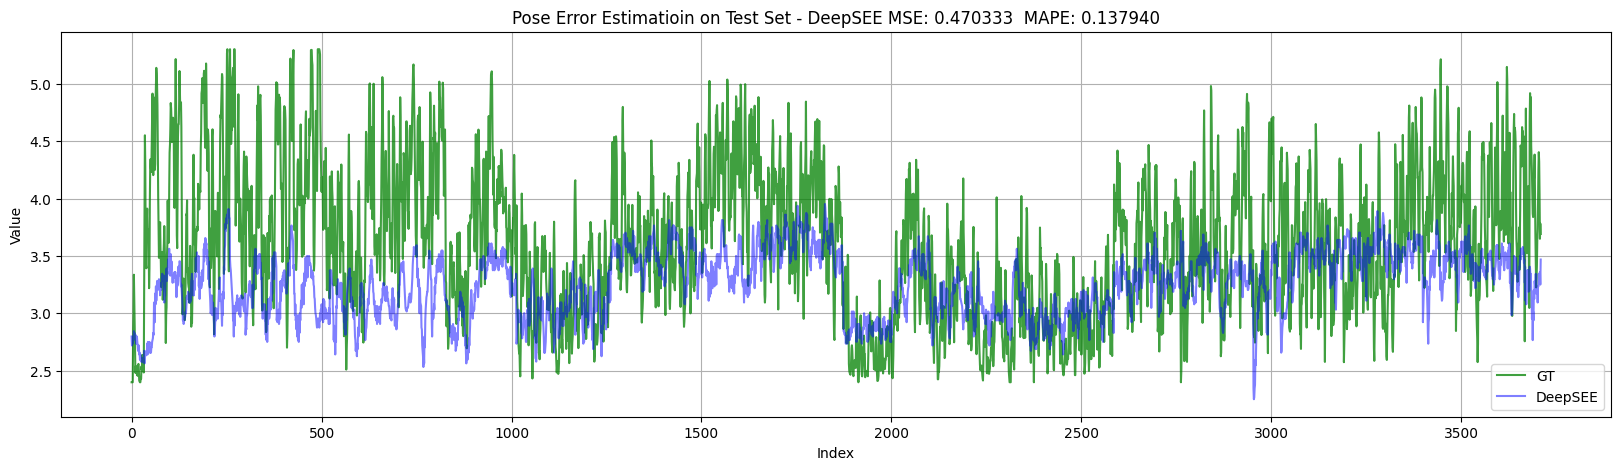

In [78]:
SupervisePretrain_Y_gt, SupervisePretrain_Y_est, _ = evaluate_on_test(model, test_loader, mode="SupervisePretrain")

In [79]:
#writer.close()

In [80]:
#sup_pretrain_train_data

# Supervised Finetuning

In [81]:
import random

def generate_random_sets(sample_number):
    groups = [['A2','A4','A7'],
                ['A3','A6','B3','B4','B5','B6','B7'],
                ['A5','B0','B1','B2']]

    finetune_split_config_list = []
    for idx in range(sample_number):
        val_list = []
        test_list = []
        train_list = []
        for group in groups:
            samples = random.sample(group, 2)
            val_list.append(samples[0])
            test_list.append(samples[1])
            train_list += [item for item in group if item not in samples]
        split_config = {
                        "sup_finetune_train_traj": {
                            "SenseTime": train_list
                        },
                        "sup_finetune_val_traj": {
                            "SenseTime": val_list
                        },
                        "sup_finetune_test_traj": {
                            "SenseTime": test_list
                        }
                    }
        finetune_split_config_list.append(split_config)
    return finetune_split_config_list


In [82]:
#generate_random_sets(10)

In [83]:
finetune_split_config_list = [
 {'sup_finetune_train_traj': {'SenseTime': ['A7',
    'A3',
    'A6',
    'B3',
    'B4',
    'B7',
    'B0',
    'B2']},
  'sup_finetune_val_traj': {'SenseTime': ['A4', 'B6', 'B1']},
  'sup_finetune_test_traj': {'SenseTime': ['A2', 'B5', 'A5']}},
 {'sup_finetune_train_traj': {'SenseTime': ['A2',
    'A3',
    'A6',
    'B3',
    'B4',
    'B5',
    'A5',
    'B0']},
  'sup_finetune_val_traj': {'SenseTime': ['A7', 'B7', 'B1']},
  'sup_finetune_test_traj': {'SenseTime': ['A4', 'B6', 'B2']}},
 {'sup_finetune_train_traj': {'SenseTime': ['A2',
    'A6',
    'B3',
    'B4',
    'B6',
    'B7',
    'A5',
    'B2']},
  'sup_finetune_val_traj': {'SenseTime': ['A7', 'B5', 'B0']},
  'sup_finetune_test_traj': {'SenseTime': ['A4', 'A3', 'B1']}},
 {'sup_finetune_train_traj': {'SenseTime': ['A7',
    'A6',
    'B4',
    'B5',
    'B6',
    'B7',
    'A5',
    'B1']},
  'sup_finetune_val_traj': {'SenseTime': ['A2', 'A3', 'B2']},
  'sup_finetune_test_traj': {'SenseTime': ['A4', 'B3', 'B0']}},
 {'sup_finetune_train_traj': {'SenseTime': ['A4',
    'A3',
    'A6',
    'B4',
    'B5',
    'B6',
    'A5',
    'B1']},
  'sup_finetune_val_traj': {'SenseTime': ['A2', 'B7', 'B2']},
  'sup_finetune_test_traj': {'SenseTime': ['A7', 'B3', 'B0']}},
 {'sup_finetune_train_traj': {'SenseTime': ['A4',
    'A6',
    'B3',
    'B4',
    'B5',
    'B6',
    'A5',
    'B0']},
  'sup_finetune_val_traj': {'SenseTime': ['A2', 'B7', 'B1']},
  'sup_finetune_test_traj': {'SenseTime': ['A7', 'A3', 'B2']}}]

In [84]:
y_pd.shape # torch.Size([5, 769, DIM])

torch.Size([5, 4, 3, 96, 128])

In [85]:
def MergeDict(dict1, dict2):
    res = {**dict1, **dict2}
    return res

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


load the best pretrained model



/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/420 [00:00<?, ?it/s]


Best validation loss: 0.40914808000837055

Saving best model for epoch: 2

Saving final model...
Best Supervised Finetuned model was saved at 2 epochs

Loss value on test set: 0.35820257663726807


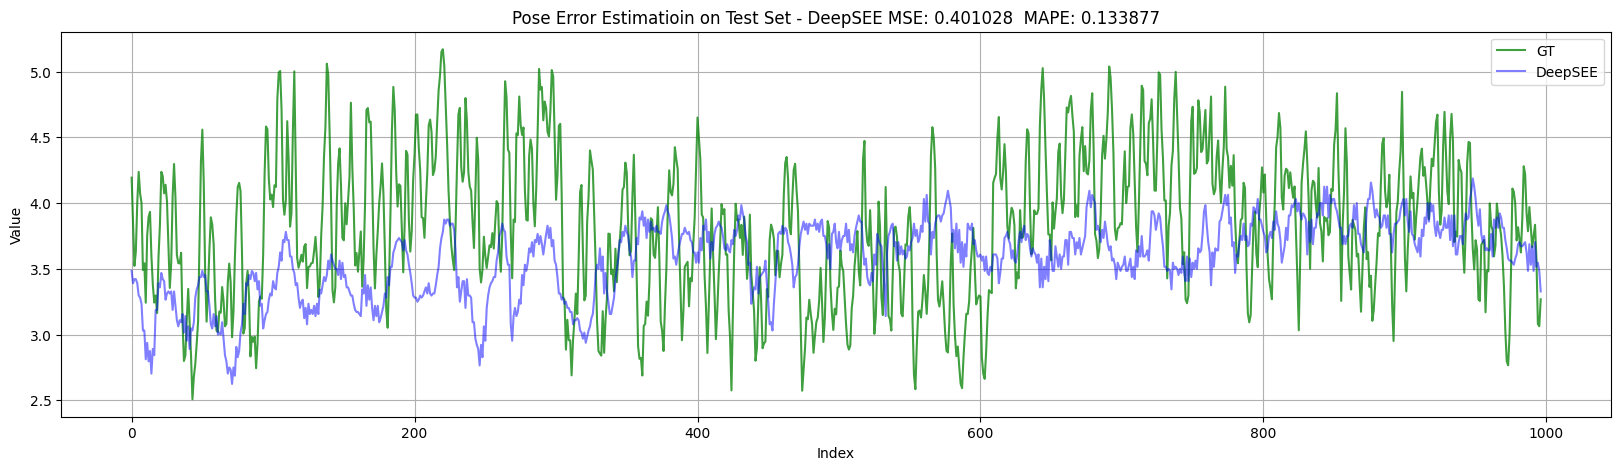

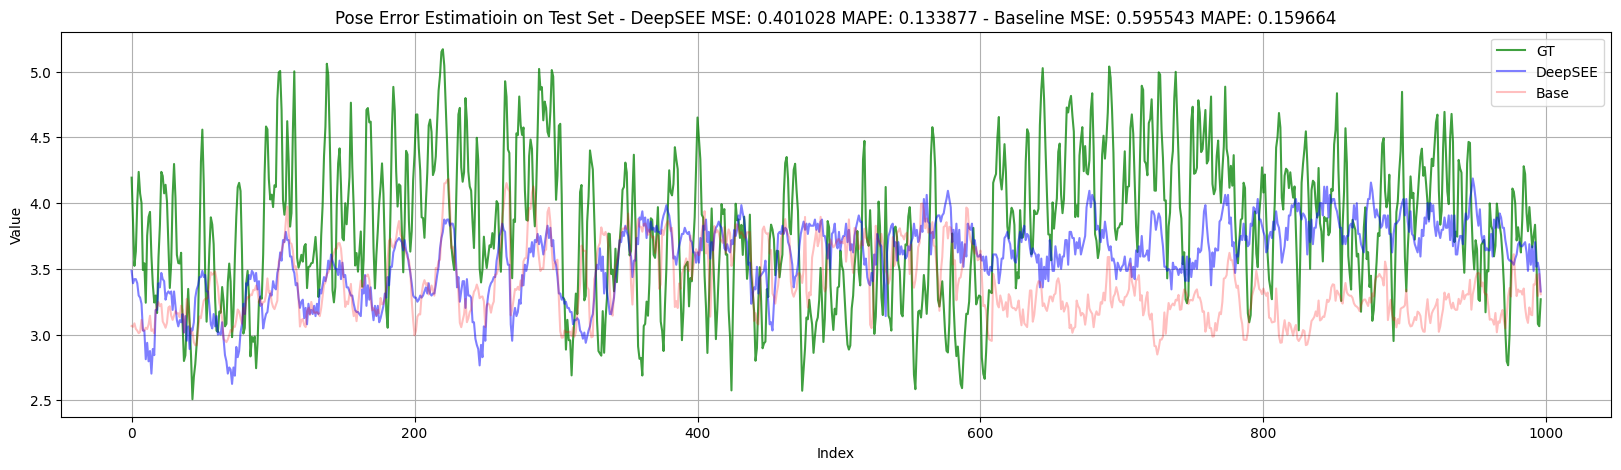

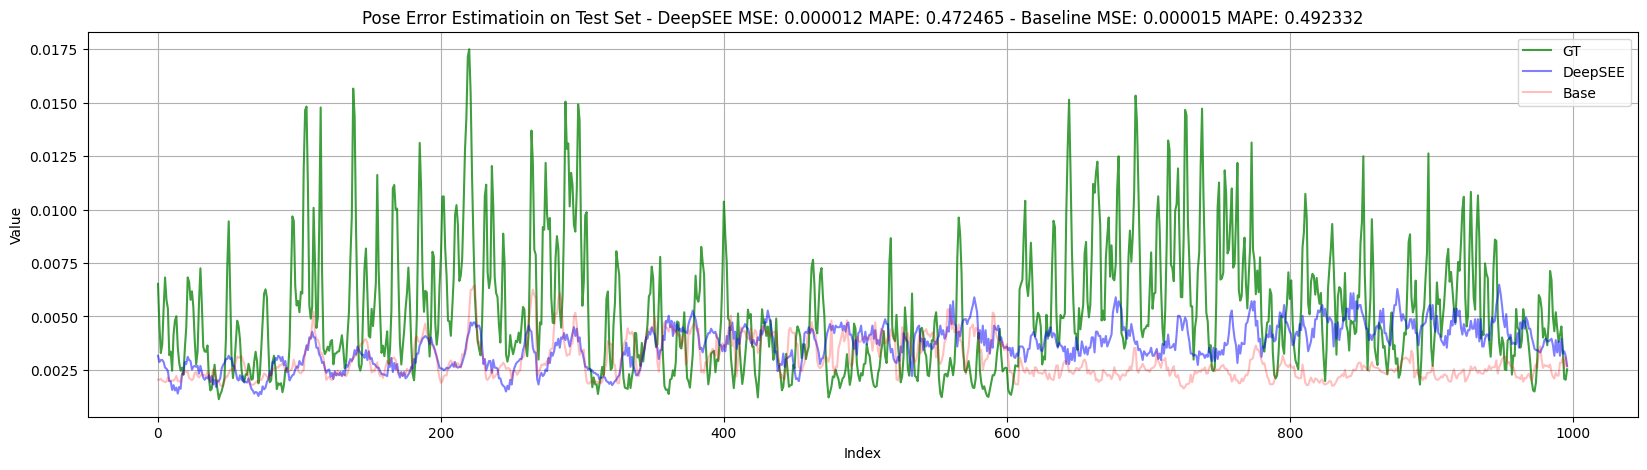

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


load the best pretrained model



/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/470 [00:00<?, ?it/s]


Best validation loss: 0.5221473649144173

Saving best model for epoch: 2


Best validation loss: 0.4932096054156621

Saving best model for epoch: 3


Best validation loss: 0.49105458458264667

Saving best model for epoch: 4


Best validation loss: 0.4770851172506809

Saving best model for epoch: 5


Best validation loss: 0.47464265922705334

Saving best model for epoch: 6

Saving final model...
Best Supervised Finetuned model was saved at 6 epochs

Loss value on test set: 0.5991809964179993


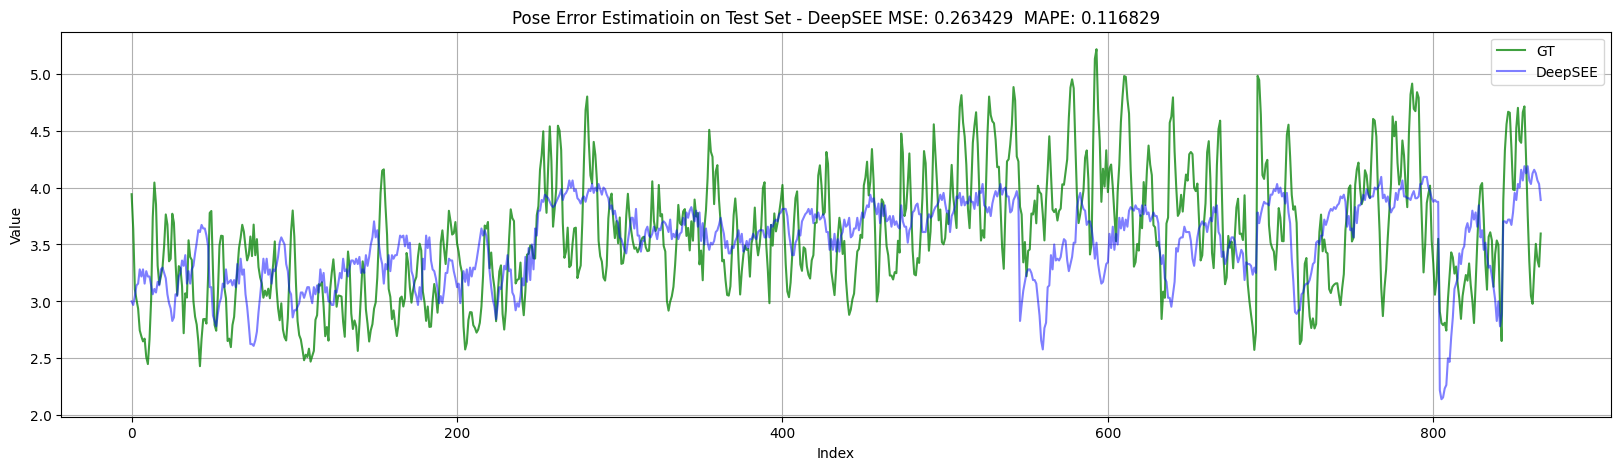

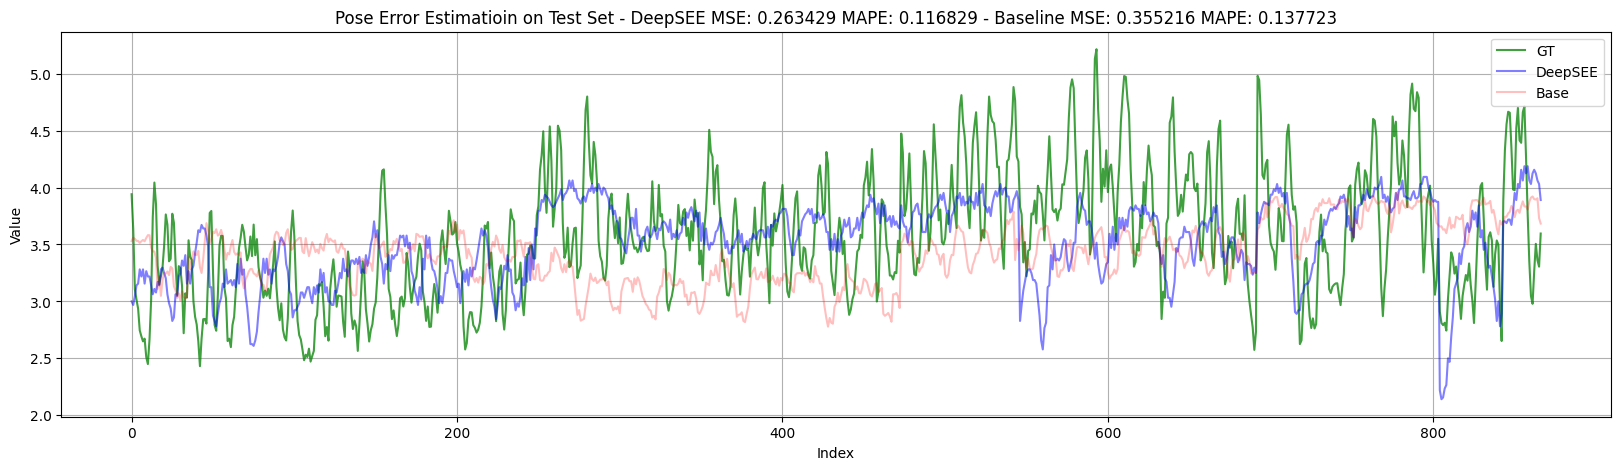

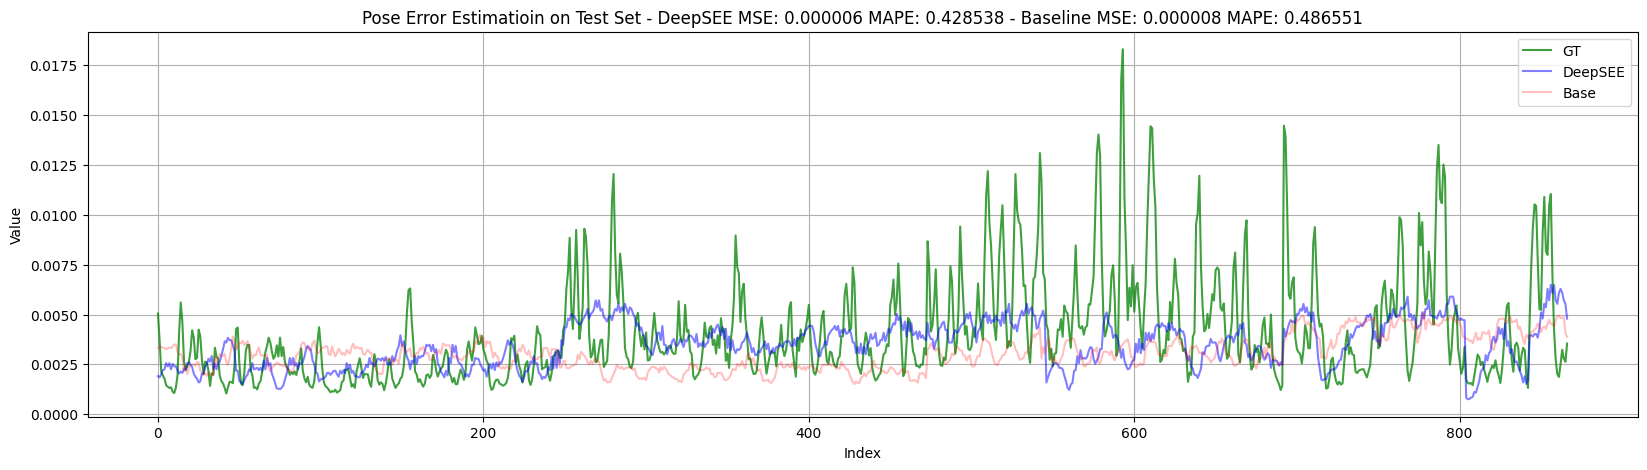

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


load the best pretrained model



/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/450 [00:00<?, ?it/s]


Best validation loss: 0.6599373031746257

Saving best model for epoch: 2


Best validation loss: 0.6057712164792147

Saving best model for epoch: 3


Best validation loss: 0.58801623637026

Saving best model for epoch: 4


Best validation loss: 0.577016444368796

Saving best model for epoch: 5


Best validation loss: 0.5326870842413469

Saving best model for epoch: 6


Best validation loss: 0.532301280986179

Saving best model for epoch: 8

Saving final model...
Best Supervised Finetuned model was saved at 8 epochs

Loss value on test set: 0.42930132150650024


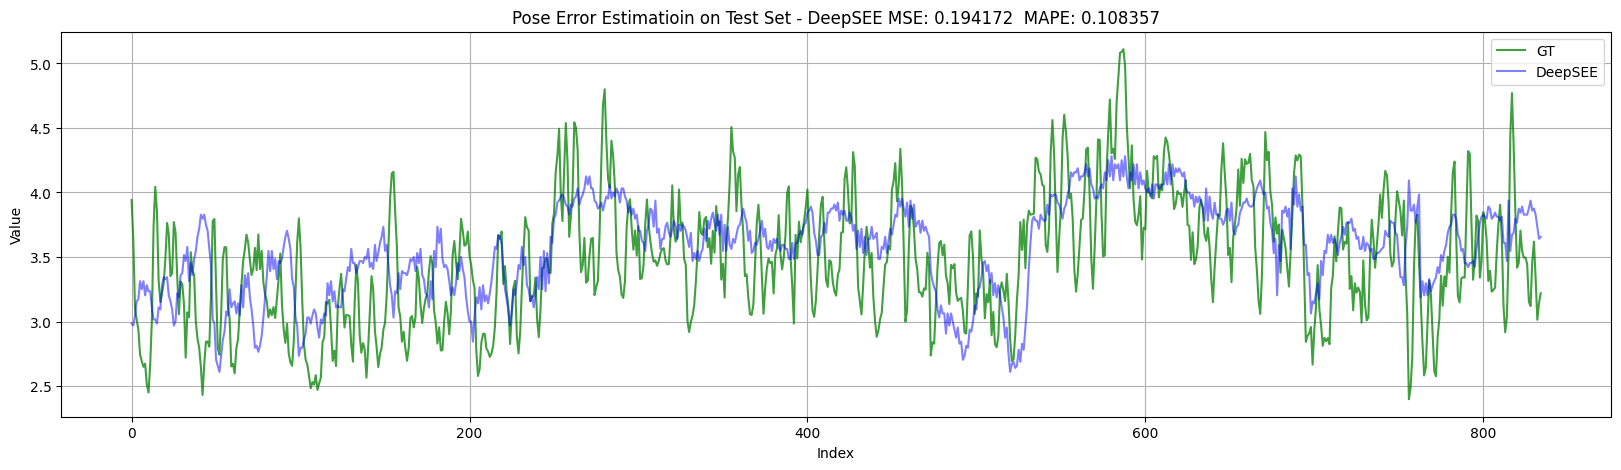

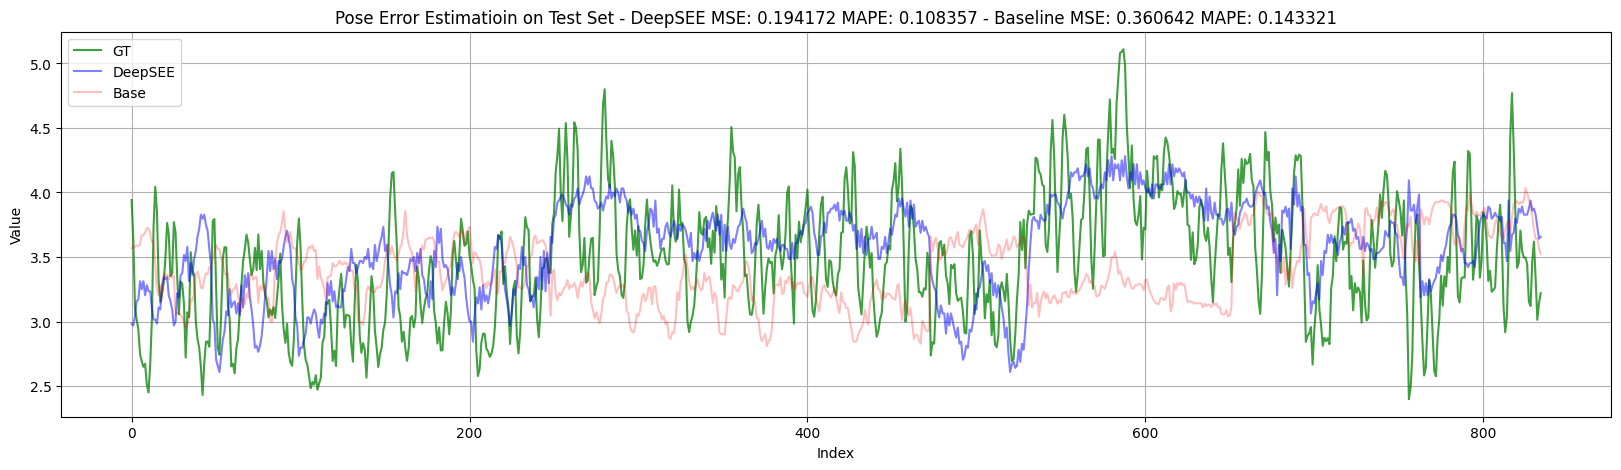

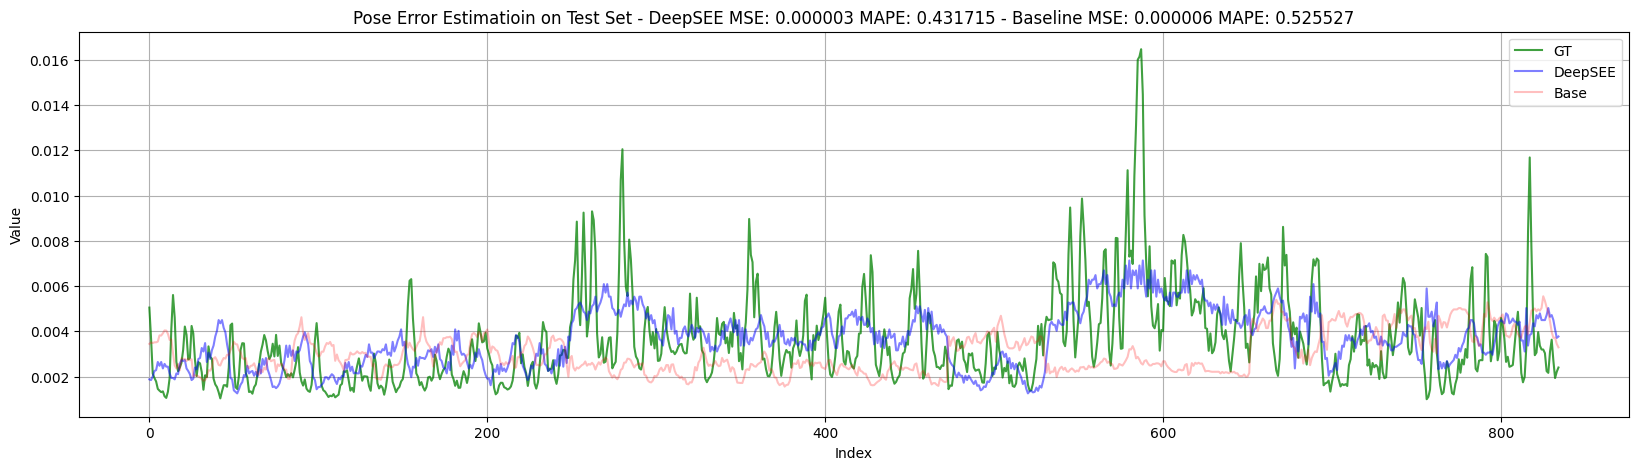

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


load the best pretrained model



/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/570 [00:00<?, ?it/s]


Best validation loss: 0.6648038594346297

Saving best model for epoch: 2


Best validation loss: 0.6644603076734041

Saving best model for epoch: 3


Best validation loss: 0.6579429224917763

Saving best model for epoch: 5

Saving final model...
Best Supervised Finetuned model was saved at 5 epochs

Loss value on test set: 0.33307135105133057


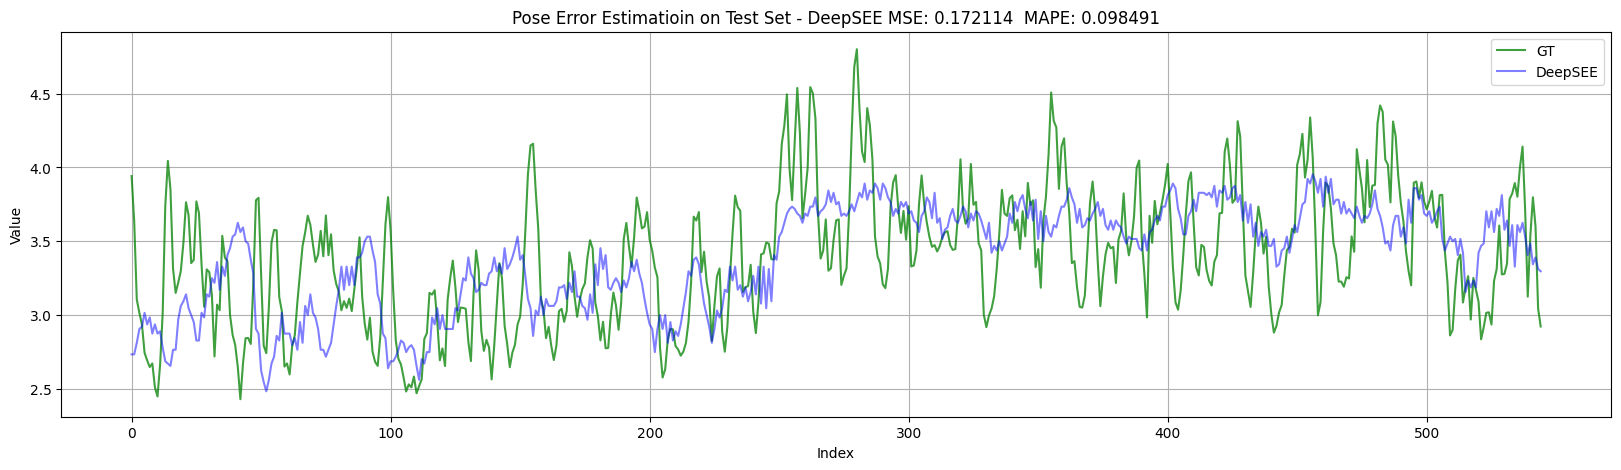

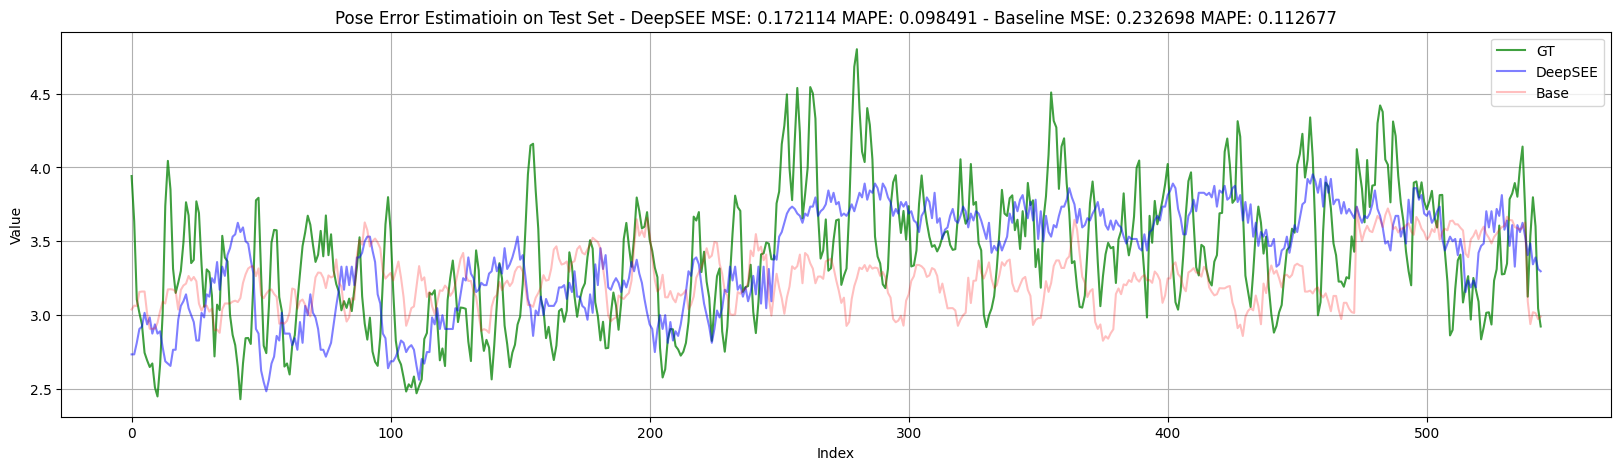

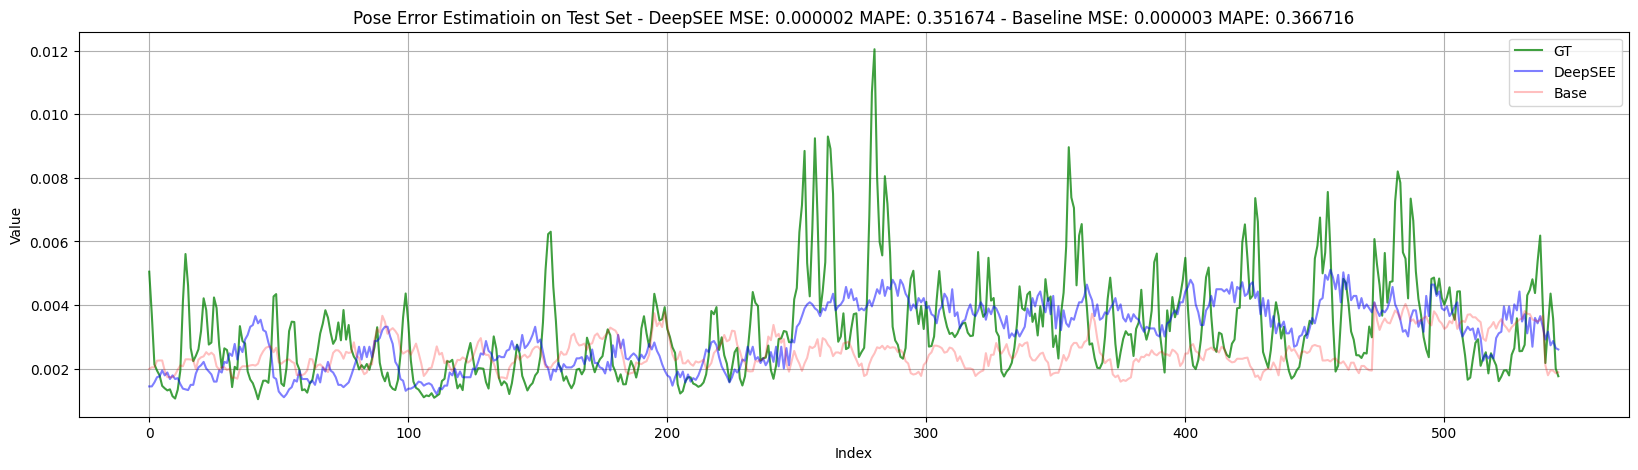

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


load the best pretrained model



/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/590 [00:00<?, ?it/s]


Best validation loss: 0.6347138567974693

Saving best model for epoch: 2

Saving final model...
Best Supervised Finetuned model was saved at 2 epochs

Loss value on test set: 0.34418782591819763


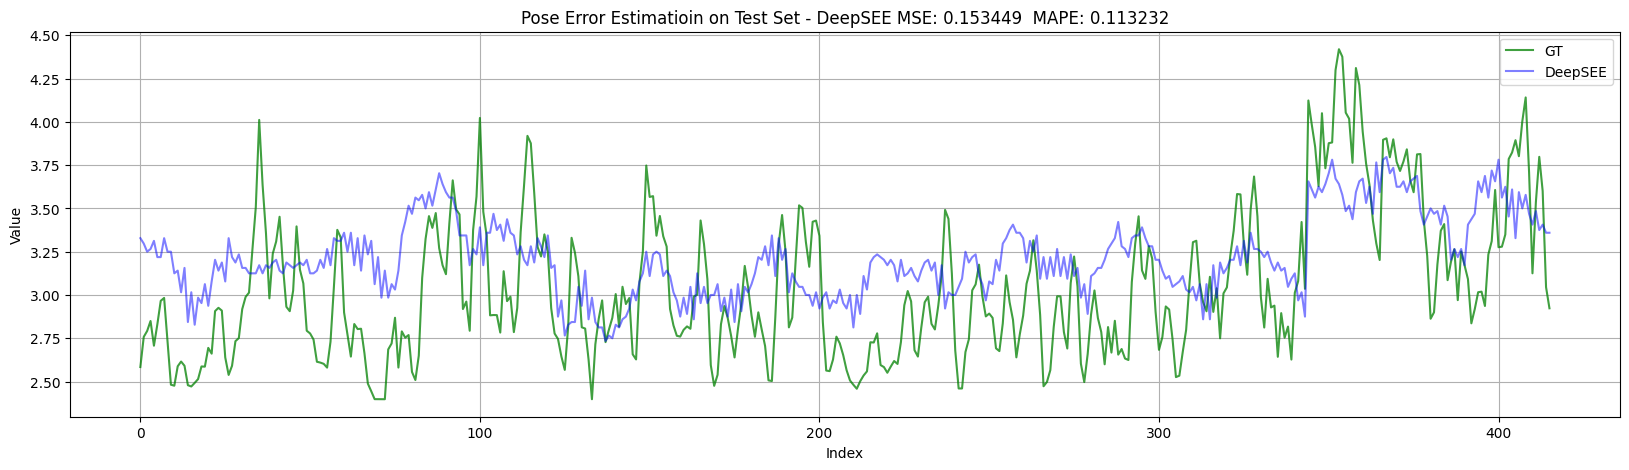

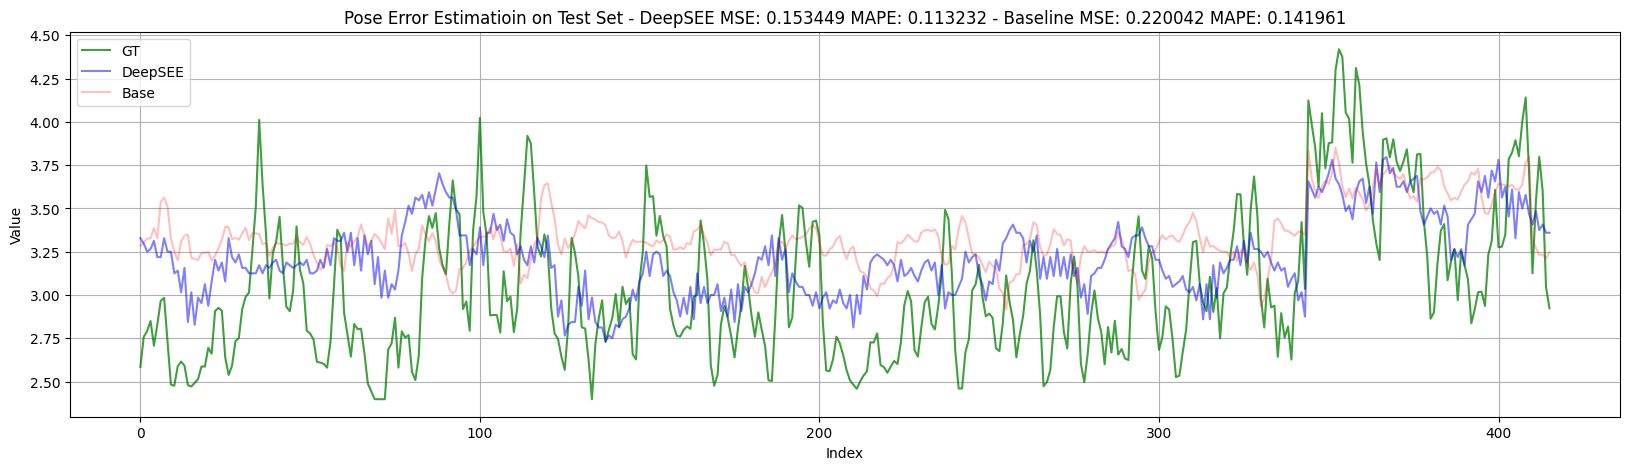

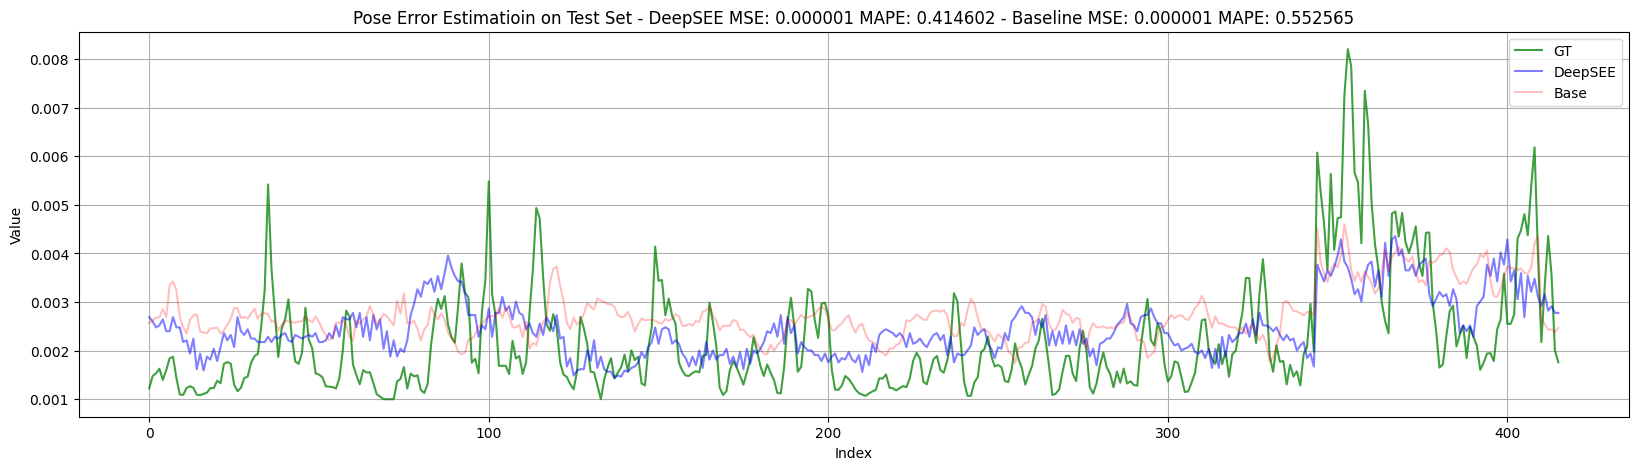

/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


load the best pretrained model



/home/tianyi/anaconda3/envs/DeepSEE/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/490 [00:00<?, ?it/s]


Best validation loss: 0.7053985695044199

Saving best model for epoch: 2

Saving final model...
Best Supervised Finetuned model was saved at 2 epochs

Loss value on test set: 0.5545719861984253


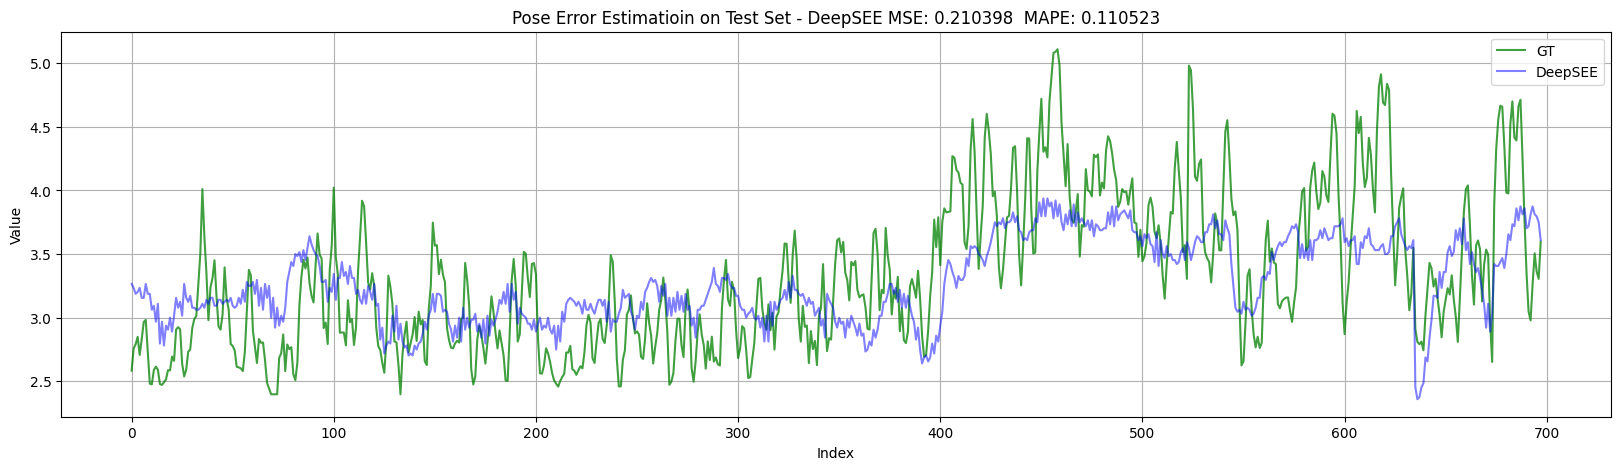

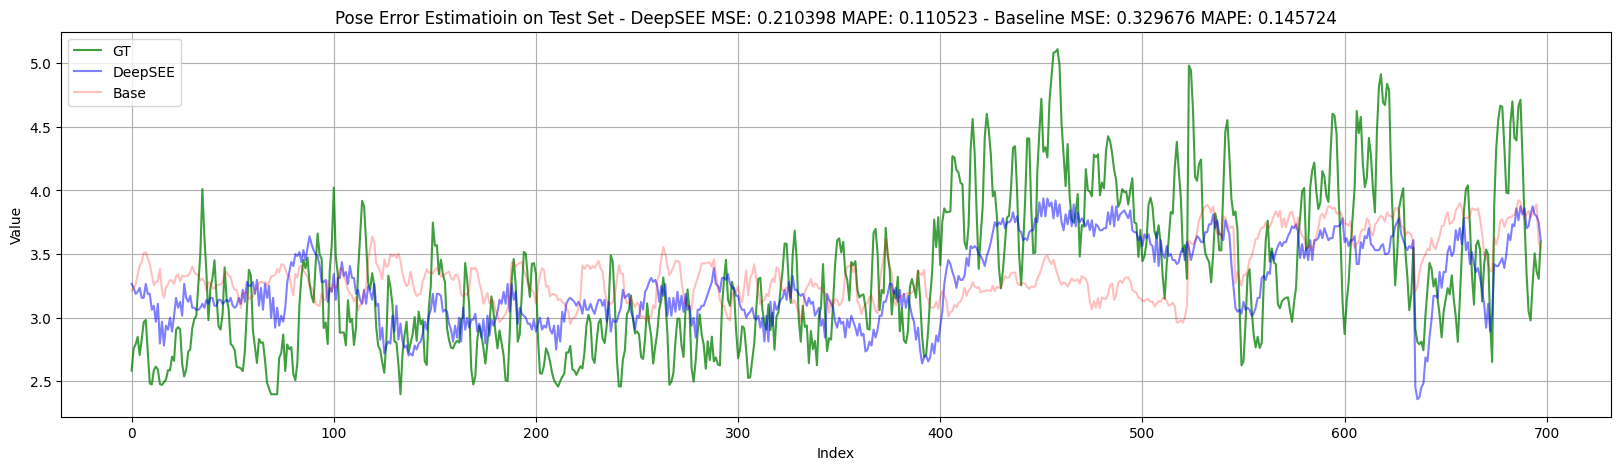

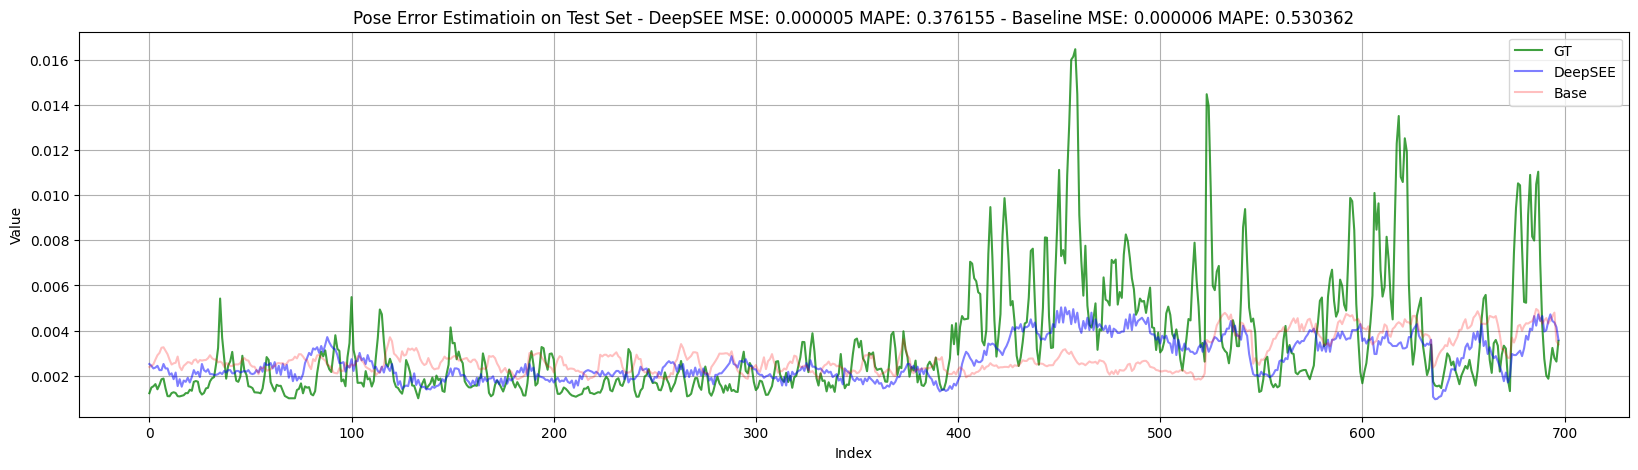

In [ ]:
all_test_DeepSEE = []
all_test_base = []
all_test_gt = []
#finetune_split_config_list = finetune_split_config_list
for idx, finetune_split_config in enumerate(finetune_split_config_list):
    # Load cross-validation assignment
    sup_finetune_train_data = assign_traj(slam_data, finetune_split_config["sup_finetune_train_traj"])
    sup_finetune_val_data = assign_traj(slam_data, finetune_split_config["sup_finetune_val_traj"])
    sup_finetune_test_data = assign_traj(slam_data, finetune_split_config["sup_finetune_test_traj"])

    # Load dataset
    sup_finetune_train_set = SLAMDataset(sup_finetune_train_data, augment=False, onlyOneIter=False, lower=lower_bound, upper=upper_bound, std=std)
    sup_finetune_val_set = SLAMDataset(sup_finetune_val_data, augment=False, onlyOneIter=False, lower=lower_bound, upper=upper_bound, std=std)
    sup_finetune_test_set = SLAMDataset(sup_finetune_test_data, augment=False, onlyOneIter=True, lower=lower_bound, upper=upper_bound, std=std)

    # Use dataset loader
    train_loader = DataLoader(sup_finetune_train_set, **train_params)
    val_loader = DataLoader(sup_finetune_val_set, **val_params)
    test_loader = DataLoader(sup_finetune_test_set, **test_params)

    # Run baseline
    sup_finetune_train_data_baseline = MergeDict(sup_finetune_train_data, sup_pretrain_train_data)
    sup_finetune_train_set_baseline = SLAMDataset(sup_finetune_train_data_baseline, augment=False, onlyOneIter=False, lower=lower_bound, upper=upper_bound, std=std)
    
    XT_train, YT_train, XT_val, YT_val, XT_test, YT_test = ensemble_tree_data_loader(sup_finetune_train_set_baseline, sup_finetune_val_set, sup_finetune_test_set)
    regr = RandomForestRegressor(n_estimators=25, max_features='sqrt', min_samples_split=2, min_samples_leaf=2, bootstrap=False, 
                        max_depth=10, random_state=0, n_jobs=-1)
    regr.fit(XT_train, YT_train)
    YT_test_head = regr.predict(XT_test)


    # DeepSEE training
    # load the best pretrained model checkpoint
    best_model_cp = torch.load('{}/SupervisedPretrain_best_model.pth'.format(writer.get_logdir()))
    best_model_epoch = best_model_cp['epoch']
    model.load_state_dict(best_model_cp['model_state_dict'])
    print(f"load the best pretrained model\n")
    finetune_config = copy.deepcopy(config)
    finetune_config.lr = config.lr
    finetune_config.epochs = 10

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last few layers 
    for param in model.ca_regressor.fc1.parameters():
        param.requires_grad = True
    for param in model.ca_regressor.fc2.parameters():
        param.requires_grad = True

    model = train_with_validation(model, train_loader, val_loader, test_loader, finetune_config, mode=f"SupervisedFinetune_{idx}")

    # Evaluation the DeepSEE model
    # load the best model checkpoint
    best_model_cp = torch.load('{}/SupervisedFinetune_{}_best_model.pth'.format(writer.get_logdir(), idx))

    best_model_epoch = best_model_cp['epoch']
    model.load_state_dict(best_model_cp['model_state_dict'])
    print(f"Best Supervised Finetuned model was saved at {best_model_epoch} epochs\n")

    SuperviseFinetune_Y_gt, SuperviseFinetune_Y_est, _ = evaluate_on_test(model, test_loader, mode=f"SupervisedFinetune_{idx}")

    plot_result_on_testset(SuperviseFinetune_Y_gt, SuperviseFinetune_Y_est, YT_test_head , mode=f"SupervisedFinetune_{idx}")

    if config.target_transform:
        plot_result_on_testset(SuperviseFinetune_Y_gt, SuperviseFinetune_Y_est, YT_test_head , mode=f"SupervisedFinetune_{idx}", target_transform=config.target_transform)
    
    all_test_gt.append(SuperviseFinetune_Y_gt)
    all_test_DeepSEE.append(SuperviseFinetune_Y_est)
    all_test_base.append(YT_test_head)

In [109]:
def get_rmse(y_gt,y_est):
    return np.sqrt(np.mean((y_gt - y_est) ** 2))

In [110]:
def get_all_numpy_array(test_tensor_list):
    y_list = [torch.concat(tensor_list) for tensor_list in test_tensor_list]
    y_array = torch.concat(y_list).cpu().numpy()
    y_array = (np.exp(y_array)-1)/10000
    return y_array

def get_each_numpy_array(test_tensor_list):
    y_array_list = [torch.concat(tensor_list).cpu().numpy() for tensor_list in test_tensor_list]
    y_array_list = [(np.exp(y_array)-1)/10000 for y_array in y_array_list]
    return y_array_list

In [111]:
test_base = np.concatenate(all_test_base)
test_base = (np.exp(test_base)-1)/10000
test_base = np.expand_dims(test_base, axis=1)
test_DeepSEE = get_all_numpy_array(all_test_DeepSEE)
test_gt = get_all_numpy_array(all_test_gt)

In [112]:
test_base_list = [np.expand_dims((np.exp(y_array)-1)/10000, axis=1) for y_array in all_test_base]
test_DeepSEE_list = get_each_numpy_array(all_test_DeepSEE)
test_gt_list = get_each_numpy_array(all_test_gt)

In [113]:
test_base_list[0].shape

(997, 1)

In [114]:
for i in range(len(test_gt_list)):
    print(f"Round{i} \t| RMSE \t | MAPE")
    print(f"Base \t| {get_rmse(test_gt_list[i], test_base_list[i])} |  {get_mape(test_gt_list[i], test_base_list[i])}")
    print(f"DeepSEE | {get_rmse(test_gt_list[i], test_DeepSEE_list[i])} |  {get_mape(test_gt_list[i], test_DeepSEE_list[i])}")

    print("="*50)

Round0 	| RMSE 	 | MAPE
Base 	| 0.003858813811236945 |  0.49233206379936073
DeepSEE | 0.0034184944815933704 |  0.47246524691581726
Round1 	| RMSE 	 | MAPE
Base 	| 0.0027533749549393193 |  0.48655119673418457
DeepSEE | 0.002477833069860935 |  0.4285384714603424
Round2 	| RMSE 	 | MAPE
Base 	| 0.002380507011072803 |  0.5255266374365766
DeepSEE | 0.0017305949004366994 |  0.43171533942222595
Round3 	| RMSE 	 | MAPE
Base 	| 0.0017606593431141906 |  0.36671551771740096
DeepSEE | 0.0014673060504719615 |  0.35167357325553894
Round4 	| RMSE 	 | MAPE
Base 	| 0.001136371404238353 |  0.5525653489401999
DeepSEE | 0.0009975585853680968 |  0.4146016538143158
Round5 	| RMSE 	 | MAPE
Base 	| 0.0024422253211914117 |  0.5303615425468078
DeepSEE | 0.0021770105231553316 |  0.3761551082134247


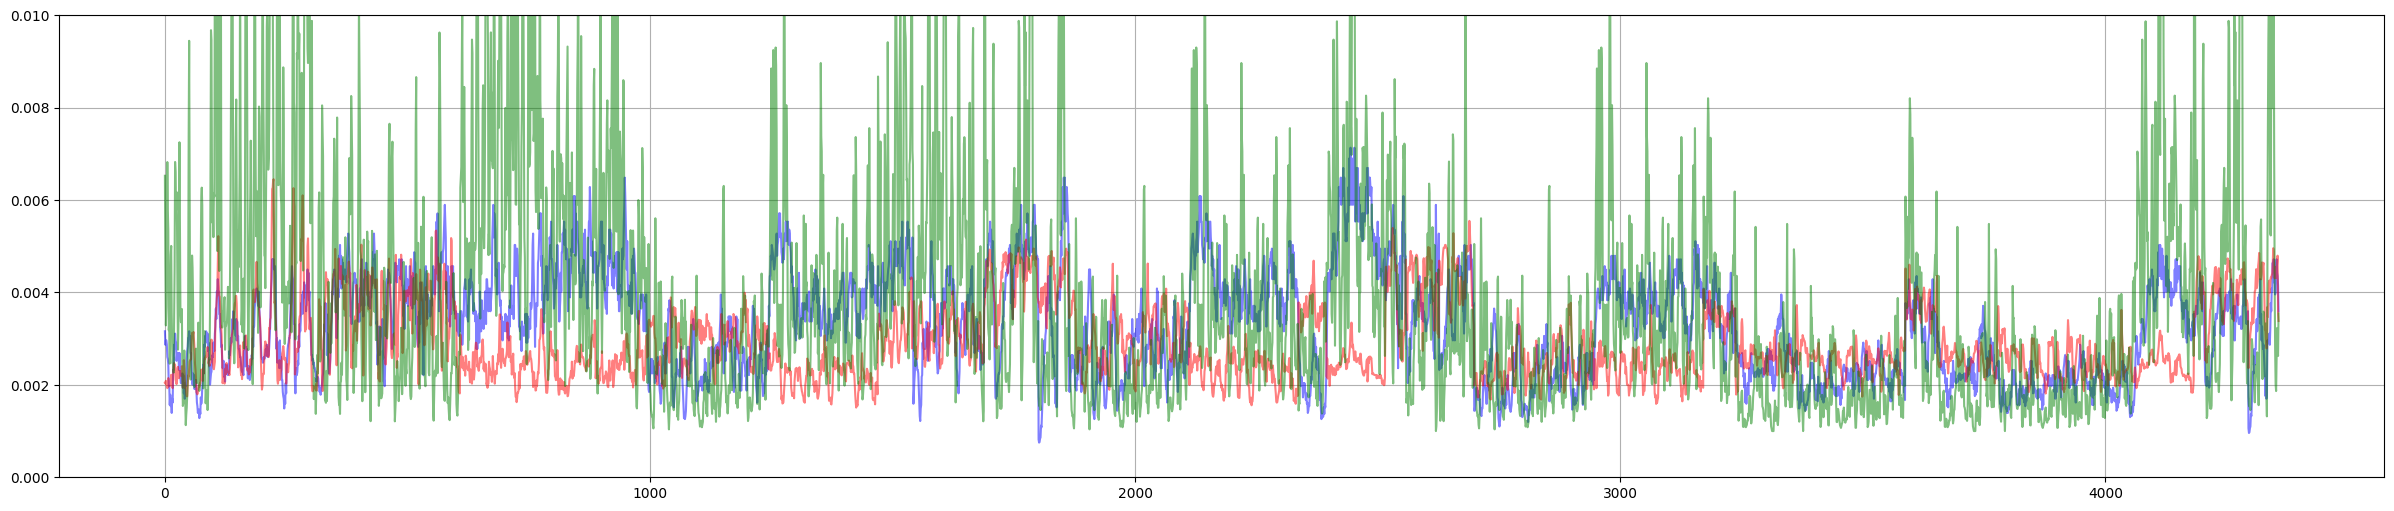

In [115]:
plt.figure(figsize=(30,6))
plt.plot(test_DeepSEE[:], c="b", alpha=0.5)
plt.plot(test_base[:], c='r', alpha=0.5)
plt.plot(test_gt, c='g', alpha=0.5)
plt.ylim(0, 0.01)
plt.grid()
plt.show()

In [116]:
print(get_rmse(test_gt, test_DeepSEE))
print(get_rmse(test_gt, test_base))

0.0023647612
0.002732539954045647


In [117]:
print(get_mape(test_gt, test_DeepSEE))
print(get_mape(test_gt, test_base))

0.4198636
0.49367351914842134


In [105]:
torch.save(model.state_dict(), writer.get_logdir() + "/test_model.pth")

In [106]:
model

DeepSEEModel(
  (pd_encoder): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(8, 8), stride=(8, 8))
      )
      (pos_drop): Dropout(p=0, inplace=False)
      (time_drop): Dropout(p=0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-2): 3 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense): Linear(in_features=192, out_feat